In [117]:
#%pip uninstall pydicom
#%pip uninstall tcia_utils
#%pip uninstall monai
#%pip uninstall rt_utils

In [118]:
#%pip install pydicom
#%pip install tcia_utils
#%pip install monai
#%pip install rt_utils
%pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [119]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
# tcia is the cancer imaging archive - for downloading  data
from tcia_utils import nbia
# medical open network for artificial intelligence - for downloading the pretrained model
#  segment the CT image, and also postproccessing
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [120]:
datadir = 'DataAIOrganSegmentation\\'

## Part 1: Open CT Image

First we'll download the CT data we'll be using to the data directory
* This data was obtained from the cancer imaging archive

In [121]:
cart_name = "nbia-56561691129779503"        # particular CT image in archive
cart_data = nbia.getSharedCart(cart_name)   # downloads
df = nbia.downloadSeries(cart_data, format="df", path=datadir)  # returns  Pandas dataframe

2024-07-26 20:08:59,430:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2024-07-26 20:09:00,264:INFO:Downloading 1 Series Instance UIDs (scans).
2024-07-26 20:09:00,832:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2024-07-26 20:09:00,834:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [122]:
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')

## Option 1: Using 'pydicom'

In [123]:
ds = pydicom.read_file(os.path.join(CT_folder, '1-394.dcm'))

In [124]:
ds      # pydicom dataset - contains metadata, info about scans, 
        #  anything about the CT scan, at the end the actual images

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.3320.3273.241712650243581113454377407120
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID      

We can obtain pixel data by accessing the 'pixel_array' attribute

In [125]:
image = ds.pixel_array  # we access the images with this
image.shape

(512, 512)

Note that the image is a 2D array. Typically the pixel values are stored in a scaled format so we should adjust them:

HU - Hounsfield units: "measurement of density"
-1000 HU - air
0 - water
+1000 - bone

In [126]:
image = ds.RescaleSlope * image + ds.RescaleIntercept

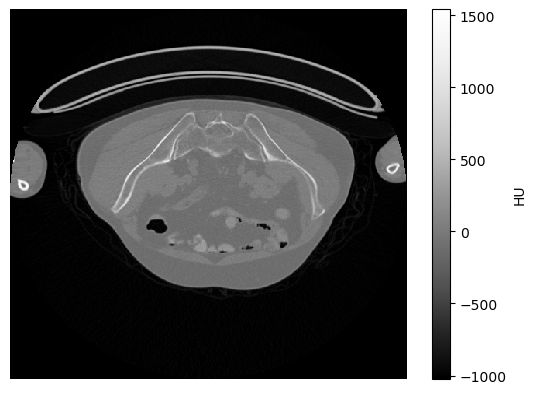

In [127]:
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

# Option 2: Usin 'monai'

MONAI stands for "Medical Open Network for Artificial Intelligence" and is essentially an extension of PyTorch for machine learning with medical data, containing **many many many** important functions. If you're doing AI research in medicine, you **must** use MONAI.

MONAI has functionality for easely opening up medical data:

In [128]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)

c:\Programming\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read DataAIOrganSegmentation\1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


The CT contains both the pixel data (for all slices) and the image metadata

In [129]:
CT.meta     # meta tensor, meta is useful for the medical imaging, 
# otherwise basically pytorch tensor but everything about metadata automatically managed

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

Now we can plot any plane of the CT image we like

In [130]:
CT_coronal_slice = CT[:,256].cpu().numpy()

View CT image

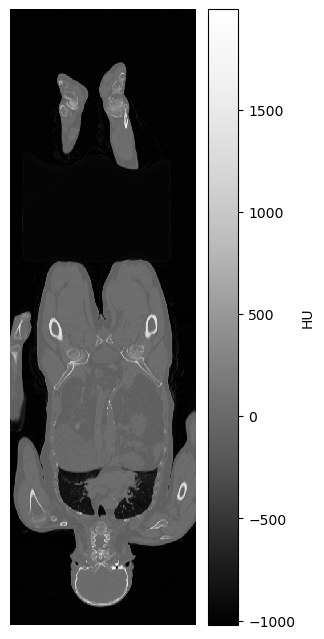

In [131]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Notice that he's upside down! We can manually reverse the axis, or we can use MONAI functionality to modify the CT: Firstly we add a channel dimension, since this is required for most AI applications

In [132]:
CT.shape    # need a channel dimension for ML (would be 3 if RGB)

torch.Size([512, 512, 975])

In [133]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

Now we can reorient the CT image:

In [134]:
orientation_transform = Orientation(axcodes=('LPS'))    # LPS = XYZ
CT = orientation_transform(CT)

Now we obtain the coronal slice

In [135]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()

Now plot again

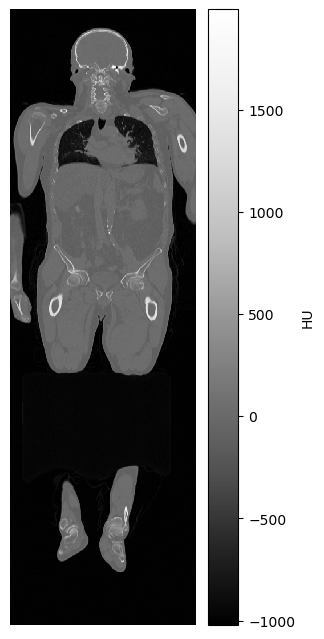

In [136]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Alternatively, we can combine all these transforms in one go when we open the image data:

In [137]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),     # loads image
    EnsureChannelFirst(),           # adds channel
    Orientation(axcodes='LPS')      # reorients correctly
])

# These pipelines are essential

And we can open suing this preprocessing pipeline:

In [138]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0,:,256].cpu().numpy()

And plot:

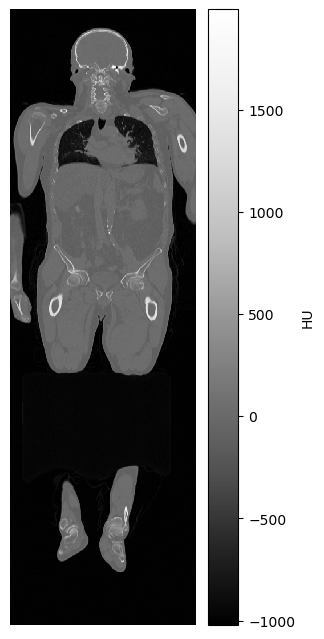

In [139]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

One other option (which is typically done) is to use the "dictionary" version of all the transforms above. This is done by adding a `d` to the end of the transforms, such as `LoadImaged`.
* These transforms take in a dictionary with keys-value pairs

In [143]:
data = {'image': CT_folder, 'some_other_key': 42}

In [144]:
data = preprocessing_pipeline(data)

RuntimeError: applying transform <monai.transforms.io.array.LoadImage object at 0x00000236BFE6ED80>

In [ ]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

## Part 2: Segmentation Model
First we'll download the segmentation model
* Obtained from https://monai.io/model-zoo.html

In [145]:
model_name = "wholeBody_ct_segmentation"
download(name=model_name, bundle_dir=datadir)

2024-07-26 20:10:15,773 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-07-26 20:10:15,773 - INFO - > name: 'wholeBody_ct_segmentation'
2024-07-26 20:10:15,773 - INFO - > bundle_dir: 'DataAIOrganSegmentation\\'
2024-07-26 20:10:15,773 - INFO - > source: 'monaihosting'
2024-07-26 20:10:15,775 - INFO - > remove_prefix: 'monai_'
2024-07-26 20:10:15,775 - INFO - > progress: True
2024-07-26 20:10:15,776 - INFO - ---


2024-07-26 20:10:16,475 - INFO - Expected md5 is None, skip md5 check for file DataAIOrganSegmentation\wholeBody_ct_segmentation_v0.2.4.zip.
2024-07-26 20:10:16,476 - INFO - File exists: DataAIOrganSegmentation\wholeBody_ct_segmentation_v0.2.4.zip, skipped downloading.
2024-07-26 20:10:16,476 - INFO - Writing into directory: DataAIOrganSegmentation.


We first set the paths of where we downloaded the model parameters (`model.pt`) and a file called `inference.json`.

In [148]:
model_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')

From this we create a `config` instance which lets us read from the `json` file

In [147]:
config = ConfigParser()
config.read_config(config_path)

## Preprocessing Pipeline
From this we can extract the preprocessing pipeline specified by the `inference.json` file
* These are all the operations applied to the data before feeding it to the model

In [149]:
preprocessing = config.get_parsed_content("preprocessing")

Note that this preprocessing pipeline uses `LoadImaged` instead of `LoadImage`. The `d` at the end refers to the fact that everything should be fed in as a dictionary. The `keys` argument are the keys of the dictionary by which to apply the transform to

In [150]:
data = preprocessing({'image': CT_folder})

In this case, the operations have only been applied to things with the key `'image'`. We could add extra keys and nothing would happen.

## Model
Now we can oobtain the model using the `'network'` key from the json file

In [151]:
model = config.get_parsed_content("network")

Note, at the moment, that the model is initialized with random parameters. We need to configure it with the parameters given by the `model.pt` file. Since we won't be training it (only use it for evaluation), we'll use the `eval()` function

In [152]:
model.load_state_dict(torch.load(model_path))
model.eval();

## Inferer
The `"inferer"` pipeline takes in the data and the model, and returns model output. It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model)

In [153]:
inferer = config.get_parsed_content("inferer")

## Postprocessing
Finally, once the model has finished running, there will be postprocessing that needs to be done on the data
* **IMPORTANT**: The postprocessing automaticcally saves the data to disk. I have manually deleted the `"SaveImaged"` from the postprocessing pipeline in the json file

In [154]:
postprocessing = config.get_parsed_content("postprocessing")

In [155]:
data['image'].unsqueeze(0).shape

torch.Size([1, 1, 167, 167, 650])

# Prediction Time :)
We can now combine all these pipelines to obtain organ masks for our data

In [156]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():  # without this you will crash your PC, 
    #  running backpropagation is extremely intensive, it's only required for training you don't need it
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

2024-07-26 20:12:15,571 INFO image_writer.py:197 - writing: C:\Programming\Tutorials\GPUPython\DataAIOrganSegmentation\mask\1.3.6.1.4.1.14519.5.2.1.3320.3273\1.3.6.1.4.1.14519.5.2.1.3320.3273_trans.nii.gz


In [157]:
slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

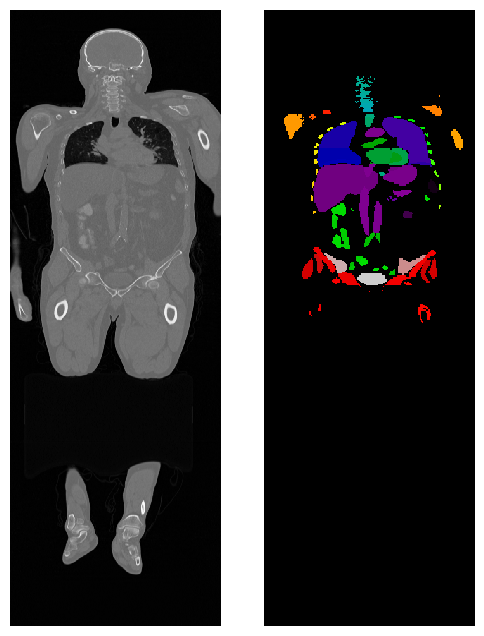

In [158]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

The mask can be used for many purposes
* Radiotherapy planning to avoid certain organs
* (My research) utilization in SPECT/PET reconstruction algorithms to improve quantitation
* Compute organ volumes

**Examples** : Computing bladder volume

In [159]:
number_bladder_voxels = (segmentation==13).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')

Bladder Volume 865.7cm^3


So now we ran the AI model and classified which areas correspond to  which organ, and we did that for all pictures of the CT scan.

Now we want to export it to a different software, we'll use `LIFEx` and here we make an account (and have to wait for cca. 6 hours to get approved for an account), then we download the software.
We open the software, import the downlaoded images to the left, and the mask file `.nii.gz` file to the right (this file contains everything the AI did).
And now we can use the software to go through individual slices and view the images much easier  than plotting all of them ourselves, it would be too slow.